In [1]:
import hyperspy.api as hs
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import binary_blobs, brick

### Create dataset

We create a synthetic EDS dataset from two EDS spectra.

In [2]:
fe = hs.load('Fe.hspy')
pt = hs.load('Pt.hspy')

<AxesSubplot:xlabel='Energy (keV)', ylabel='Intensity'>

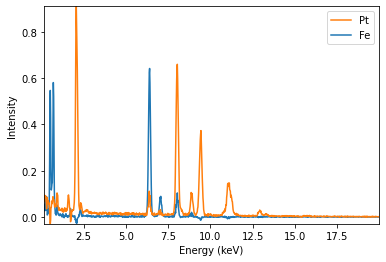

In [3]:
hs.plot.plot_spectra([fe, pt], legend=['Fe', 'Pt'])

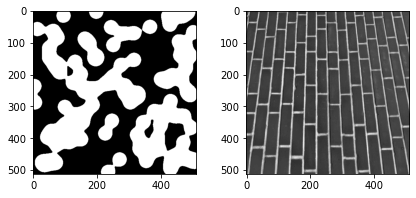

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].imshow(binary_blobs(), cmap='gray')
axs[1].imshow(brick(), cmap='gray')

In [5]:
def create_dask_array(signal_chunk=1):
    nav0 = 150 * binary_blobs().flatten() * da.random.random((512 * 512), chunks=(1024*8*signal_chunk,))
    sig0 = da.from_array(fe.data, fe.data.shape[0] / signal_chunk)
    data0 = da.outer(nav0, sig0).reshape((512, 512, fe.data.shape[0]))

    nav1 = brick().flatten() * da.random.random((512 * 512), chunks=(1024*8*signal_chunk,))
    sig1 = da.from_array(pt.data, pt.data.shape[0] / signal_chunk)
    data1 = da.outer(nav1, sig1).reshape((512, 512, pt.data.shape[0]))

    return data0 + data1

In [6]:
data = create_dask_array(4)

In [7]:
data

dask.array<add, shape=(512, 512, 992), dtype=float64, chunksize=(64, 512, 248), chunktype=numpy.ndarray>

In [8]:
s = hs.signals.EDSTEMSpectrum(data).as_lazy()
axis = s.axes_manager[-1]
axis_ref = fe.axes_manager[-1]
for attr in ('scale', 'units', 'offset'):
    setattr(axis, attr, getattr(axis_ref, attr))
s.add_elements(('Fe', 'Pt'))

In [9]:
s.axes_manager

Navigation axis name,size,index,offset,scale,units
,512,0,0.0,1.0,
,512,0,0.0,1.0,
Signal axis name,size,,offset,scale,units
,992,,0.16,0.02,keV


### Save dataset

In [10]:
s.save('synthetic_dataset.hspy')

Save a dataset with a single chunk in the signal dimension

In [11]:
s.data = create_dask_array(1)

In [12]:
s.data

dask.array<add, shape=(512, 512, 992), dtype=float64, chunksize=(16, 512, 992), chunktype=numpy.ndarray>

In [13]:
s.save('synthetic_dataset_chunking.hspy')